In [1]:
import pandas as pd
import numpy as np

import lenskit.crossfold as xf
from lenskit.metrics.topn import precision, recall, ndcg 
from lenskit.algorithms.als import ImplicitMF
from lenskit.metrics.topn import precision, recall, ndcg 
from lenskit import topn, util
from lenskit.algorithms import Recommender
from lenskit.batch import recommend
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()
from collections import Counter

import math


# !!! DONOT RUN NEXT PARTS UNTIL PART WHERE I SAY SO !!!

## Reading data and preliminary evaluation

In [94]:
# Read artists per user, while taking user_id as user and artist_id as item in order to perform implicit matrix factorization for recommendations
spotify_track = pd.read_csv("participant data updated Nov 22/user spotify data/top_tracks.csv").rename(
columns={"user_id": "user",
        "track_id": "item"})
spotify_track#[51:101]


,user,item,time_period,timestamp,position
0,d28708a363b58062087293f779256fffa38fdd56c1f79d...,538mGMhcnSva7oMoAviUPf,medium,1.666364e+09,0
1,d28708a363b58062087293f779256fffa38fdd56c1f79d...,4ADhzINVrX053tN4xVIjh1,medium,1.666364e+09,1
2,d28708a363b58062087293f779256fffa38fdd56c1f79d...,4xNDbq22jC2Vdf6QV2uArL,medium,1.666364e+09,2
3,d28708a363b58062087293f779256fffa38fdd56c1f79d...,0Wcm43LYI2UD1dOrAU7Wig,medium,1.666364e+09,3
4,d28708a363b58062087293f779256fffa38fdd56c1f79d...,2eJovRJ0mGlWltuhKMgJKM,medium,1.666364e+09,4
...,...,...,...,...,...
10404,9a56b76ebcc78e6344d0860dc4ba0586fbb59a390c95d3...,5gFNyR3qCTTgMjvzh9kHoD,long,1.668977e+09,45
10405,9a56b76ebcc78e6344d0860dc4ba0586fbb59a390c95d3...,7lQWRAjyhTpCWFC0jmclT4,long,1.668977e+09,46
10406,9a56b76ebcc78e6344d0860dc4ba0586fbb59a390c95d3...,6VObnIkLVruX4UVyxWhlqm,long,1.668977e+09,47
10407,9a56b76ebcc78e6344d0860dc4ba0586fbb59a390c95d3...,140Gw2YEm6CjfxDwe2vzba,long,1.668977e+09,48


In [95]:
# Distribution of term times
spotify_track.time_period.value_counts()

long      3612
medium    3509
short     3288
Name: time_period, dtype: int64

In [96]:
# Identify least amount of tracks for an user and see which 'term' length this has
spotify_track.user.value_counts()

d8581c0b6444ce0db8aada1e44c7f812ff35bbc1eb90531d6989850befb652a5    166
d5e9218e4154b107858c7461b050e589e53b02f91517d2c6e8ca6c2eb1c217f9    162
03f7301371fb3685335418eb7dc01c3c8320da40018081424eba07e305a06376    160
dee23052c0f120382f9e262a744db2512c8317c94243eb348b2e663aec7436f1    156
8392926e1ae697163624c8a090cf69be21e6c3b96f5caea8b08c5fcb829fbe13    154
                                                                   ... 
52d7d624aa9487bd1a3178b36570ecca27e2f39bfe0308402d7cb0babf6f84bb    101
2ef41e03eea7359470b492771ef78ac792437960561b744f2c2bf6accaca15f6     57
1418fcc80d2e4febb58f44fcd93ff755df16b64edfa90076ab6e6707d79453ba     53
32dbeaad7fa194eadff4c90a20d504390d86bcfcc93c2a6ce1826b6d0d3c2979      3
93c25a1d7af16a3f513dc53f3d1334c4a7f2df82925e215c110a7ba541c0bb9f      2
Name: user, Length: 74, dtype: int64

In [97]:
# Least amount of users given tracks
spotify_track.loc[spotify_track['user'] == '93c25a1d7af16a3f513dc53f3d1334c4a7f2df82925e215c110a7ba541c0bb9f']

,user,item,time_period,timestamp,position
3153,93c25a1d7af16a3f513dc53f3d1334c4a7f2df82925e21...,5GQAHsTo4DI71QLAXUo3DV,long,1.668428e+09,0
3154,93c25a1d7af16a3f513dc53f3d1334c4a7f2df82925e21...,46N0cSUeoKfdGOGG852Jk1,long,1.668428e+09,1


## Preprocessing
Extra preprocessing based on above finding. Otherwise multiple recommendations based on periods and overlap between them. Only looking at the long term time period, says the most about the users prefference and short time period might be influenced by things such as holidays and thus fitting music for that period. For this reason the long term is taken into accout

In [98]:
# Only keep the rows in which the time period is long > this present for all persons, so we can recommend for all.
# Short and medium term are removed
# spotify_track = spotify_track.loc[spotify_track['time_period'] == 'long']
# spotify_track

## Part 2 - Calculating il-diversity and after max/min diversification

- current diversity per user
- calculate lower diversity list 
- calculate higher diversity list

- diversify on stuff other than genre --> Song characteristics/features but not too far
  - contour plot of feature values for current diversity
  - include given feature preference by user --> stay close
- also possible to use artists instead of genre 


# PART 1. Ouput given by victor in future
Now generated as I need the recommendations in order to diversify them. So delete this part when connencting with part 1.

In [99]:
# Split data and do cross validation for optimal hyperparameters. 
# Set the partition number and split the dataframe into 5 folds, 
# xf.SampleFrac(0.2): 0.2 percent ratings are took for testing" 

partitions = 5
for i, tp in enumerate(xf.partition_users(spotify_track, partitions, xf.SampleFrac(0.2), rng_spec=2022)):
    tp.train.to_csv('spot-latest-small-exp/train-%d.csv' % (i,))
    tp.test.to_csv('spot-latest-small-exp/test-%d.csv' % (i,))

In [100]:
# Function for build matrix facotrization
def ImplicitMFTopN(partitions=5, features=10, n=10):
    mean_precision = 0
    mean_recall = 0
    mean_ndcg = 0
    for i in range(partitions):
        implicitmf_Recs = ImplicitMF(features=features, iterations=20, reg=0.15)

        # load training data and testing data
        train = pd.read_csv('spot-latest-small-exp/train-%d.csv' % (i,))
        test = pd.read_csv('spot-latest-small-exp/test-%d.csv' % (i,))

        # train the user knn model with training data
        fittable = util.clone(implicitmf_Recs)
        fittable = Recommender.adapt(fittable)
        fittable.fit(train)
        
        # get the unique test users
        users = test.user.unique()
        
        # recommend the top n recommendations users 
        recs = recommend(fittable, users, n)
        rla = topn.RecListAnalysis()
        
        #evaluate with precision
        rla.add_metric(topn.precision, k=n)
        rla.add_metric(topn.recall, k=n)
        rla.add_metric(topn.ndcg, k=n)
        results = rla.compute(recs, test)
        mean_precision = mean_precision + results.precision.mean()
        mean_recall = mean_recall + results.recall.mean()
        mean_ndcg = mean_ndcg + results.ndcg.mean()
    
    mean_precision = mean_precision/partitions
    mean_recall = mean_recall/partitions
    mean_ndcg = mean_ndcg/partitions
    # return the average precision for all users
    return mean_precision, mean_recall, mean_ndcg

In [101]:
pre, recall, ndcg = ImplicitMFTopN(partitions=5, features=25, n=10)
print(pre)
print(recall)
print(ndcg)


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

0.03133333333333334
0.03133333333333334
0.03085648479777255


For now keep all time periods included, eventhough this gives the following warning: truth index not unique: may have duplicate items. But want to recommend overall, based on short, medium and long term

In [102]:
# DROP FOR studnets
# number of latent features
num_features = np.arange(20, 150, 10, dtype=int)

# store the results for different nnbrs
results_pre = {}
results_recall = {}
results_ndcg = {}

for num_f in num_features:
    print(num_f)
    pre, recall, ndcg = ImplicitMFTopN(partitions=5, features=num_f, n=10)
    results_pre[num_f] = pre
    results_recall[num_f] = recall
    results_ndcg[num_f] = ndcg

20


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

30


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

40


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

50


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

60


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

70


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

80


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

90


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

100


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

110


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

120


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

130


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

140


truth index not unique: may have duplicate items
                                  Unnamed: 0 time_period     timestamp  \
LKTruthID item                                                           
0         0E4Y1XIbs8GrAT1YqVy6dq        8560       short  1.668685e+09   
          1eyqSYBCTane4rl4vc6PWJ        8461      medium  1.668685e+09   
          6kISMRfweKSvgHR0urMQFG        8467      medium  1.668685e+09   
          5H8fYiRySoxCnsjVzV67HO        8600      medium  1.668685e+09   
          30cW9fD87IgbYFl8o0lUze        8610      medium  1.668685e+09   
...                                      ...         ...           ...   
13        7vdmxftpUdeBzOf6NXjm83        5336       short  1.668444e+09   
          3DBZqOpuCJOPHSEGM9bzl5        5275       short  1.668444e+09   
          0GbBLC50dJxjPiTglbxcy6        5385      medium  1.668444e+09   
          0ZUo4YjG4saFnEJhdWp9Bt        5386      medium  1.668444e+09   
          3z9Kma9ewHSAemFewFrXoJ        5367       short  1.668

<AxesSubplot:xlabel='num_of_features', ylabel='Precision'>

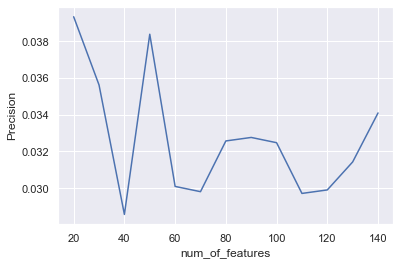

In [103]:
df_results_pre = pd.DataFrame.from_dict(results_pre, orient='index').reset_index().rename(
    columns={"index": "num_of_features", 0: "Precision"})

sns.lineplot(
    data=df_results_pre,
    x="num_of_features", y="Precision", markers=True, dashes=False
)

<AxesSubplot:xlabel='num_of_features', ylabel='Recall'>

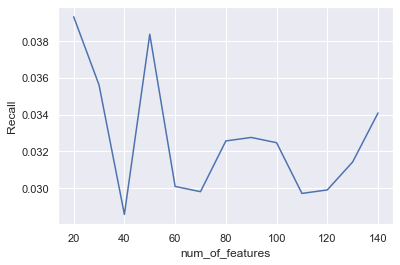

In [104]:
df_results_recall = pd.DataFrame.from_dict(results_recall, orient='index').reset_index().rename(
    columns={"index": "num_of_features", 0: "Recall"})

sns.lineplot(
    data=df_results_recall,
    x="num_of_features", y="Recall", markers=True, dashes=False
) 

<AxesSubplot:xlabel='num_of_features', ylabel='NDCG'>

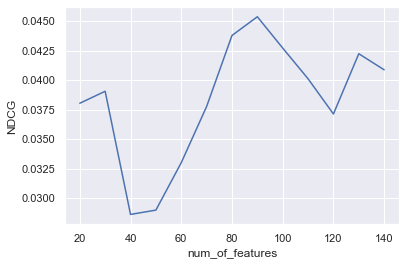

In [105]:
df_results_ndcg = pd.DataFrame.from_dict(results_ndcg, orient='index').reset_index().rename(
    columns={"index": "num_of_features", 0: "NDCG"})

sns.lineplot(
    data=df_results_ndcg,
    x="num_of_features", y="NDCG", markers=True, dashes=False
)

Real recommendation based on optimal number of features. As can be seen in plots above, this is best at 90. Afterwards, it starts decreasing again, but also some increasing but mostly decreasing. Unknown if more features might give a better result. (Limitation to mention for discussion possibly)

In [106]:
optimal_feature = 90

In [107]:
for i, tp in enumerate(xf.partition_users(spotify_track, partitions=1, method=xf.SampleFrac(0.2), rng_spec=2022)):
    tp.train.to_csv('spot_train_test/train-%d.csv' % (i,))
    tp.test.to_csv('spot_train_test/test-%d.csv' % (i,))
    #Train the recommender with optimal hyperparameters
    implicitmf_Recs = ImplicitMF(features=optimal_feature)

    # train the user knn model with training data
    fittable = util.clone(implicitmf_Recs)
    fittable = Recommender.adapt(fittable)
    fittable.fit(tp.train)

    # get the unique test users
    users = tp.test.user.unique()

    # recommend the top 50 recommendations users 
    recs = recommend(fittable, users, 50)
    rla = topn.RecListAnalysis()

# START RUNNING FROM HERE
# Part 2. Different ways of diversification of recommended items
if I have a list with recommendations. Unsure in what format/including columns Victor is going to deliver his part, so possibly some overlap as well.

In [82]:
recs_diverse = pd.read_csv("participant data updated Nov 22/recommendations_diverse.csv").rename(
columns={"user_id": "user",
        "id": "item"})
recs_non_diverse = pd.read_csv("participant data updated Nov 22/recommendations_non_diverse.csv").rename(
columns={"user_id": "user",
        "id": "item"})
recs_diverse = recs_diverse[recs_diverse['item'].notna()]
recs_non_diverse = recs_non_diverse[recs_non_diverse['item'].notna()]

In [83]:
recs_non_diverse
recs_diverse

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,tempo,type,item,uri,track_href,analysis_url,duration_ms,time_signature,user,rank
0,0,0.658,0.930,5,-2.912,0,0.1410,0.02360,0.000000,0.5780,...,104.018,audio_features,1RJZLVGpBG9nNZiHRQSWTp,spotify:track:1RJZLVGpBG9nNZiHRQSWTp,https://api.spotify.com/v1/tracks/1RJZLVGpBG9n...,https://api.spotify.com/v1/audio-analysis/1RJZ...,237680,4,d28708a363b58062087293f779256fffa38fdd56c1f79d...,1
1,1,0.377,0.182,6,-10.896,1,0.0303,0.69000,0.000000,0.1100,...,151.630,audio_features,3Y315h4E3Oc1rGdpr6Mxr9,spotify:track:3Y315h4E3Oc1rGdpr6Mxr9,https://api.spotify.com/v1/tracks/3Y315h4E3Oc1...,https://api.spotify.com/v1/audio-analysis/3Y31...,245987,3,d28708a363b58062087293f779256fffa38fdd56c1f79d...,2
2,2,0.638,0.441,8,-6.909,0,0.0290,0.41500,0.000079,0.1100,...,117.933,audio_features,68tZwwRuo9ip5gRQFG1XWF,spotify:track:68tZwwRuo9ip5gRQFG1XWF,https://api.spotify.com/v1/tracks/68tZwwRuo9ip...,https://api.spotify.com/v1/audio-analysis/68tZ...,271493,4,d28708a363b58062087293f779256fffa38fdd56c1f79d...,3
3,3,0.696,0.837,0,-5.034,0,0.1180,0.06470,0.000000,0.1130,...,153.294,audio_features,53a8WmHKKrxhDiBRGqDlgV,spotify:track:53a8WmHKKrxhDiBRGqDlgV,https://api.spotify.com/v1/tracks/53a8WmHKKrxh...,https://api.spotify.com/v1/audio-analysis/53a8...,246453,4,d28708a363b58062087293f779256fffa38fdd56c1f79d...,4
4,4,0.429,0.345,9,-9.724,0,0.0371,0.85800,0.000000,0.2680,...,133.139,audio_features,1GWsEPe6pIYlqrNFEMExdX,spotify:track:1GWsEPe6pIYlqrNFEMExdX,https://api.spotify.com/v1/tracks/1GWsEPe6pIYl...,https://api.spotify.com/v1/audio-analysis/1GWs...,268625,4,d28708a363b58062087293f779256fffa38fdd56c1f79d...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,95,0.781,0.973,4,-2.517,0,0.0890,0.01280,0.464000,0.0957,...,124.001,audio_features,3dsPwEkyPmsvrJRssBDHHW,spotify:track:3dsPwEkyPmsvrJRssBDHHW,https://api.spotify.com/v1/tracks/3dsPwEkyPmsv...,https://api.spotify.com/v1/audio-analysis/3dsP...,280645,4,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,96
4496,96,0.377,0.108,9,-23.493,1,0.0332,0.91600,0.981000,0.1700,...,118.576,audio_features,6W4OTAu8XW5p2Ac4aAIUDl,spotify:track:6W4OTAu8XW5p2Ac4aAIUDl,https://api.spotify.com/v1/tracks/6W4OTAu8XW5p...,https://api.spotify.com/v1/audio-analysis/6W4O...,260620,4,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,97
4497,97,0.749,0.857,0,-5.022,1,0.0347,0.00156,0.033000,0.1780,...,125.045,audio_features,6Nx4KqZLoLF0gG0eMfEuBS,spotify:track:6Nx4KqZLoLF0gG0eMfEuBS,https://api.spotify.com/v1/tracks/6Nx4KqZLoLF0...,https://api.spotify.com/v1/audio-analysis/6Nx4...,299520,4,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,98
4498,98,0.811,0.928,0,-4.367,1,0.0390,0.02580,0.007960,0.0436,...,123.998,audio_features,2glRwrbsXM6p1AW1UESGtS,spotify:track:2glRwrbsXM6p1AW1UESGtS,https://api.spotify.com/v1/tracks/2glRwrbsXM6p...,https://api.spotify.com/v1/audio-analysis/2glR...,196976,4,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,99


In [109]:
# Get the top 10 recommendations
# recs_meta_top10 = recs_meta[recs_meta["rank"] <= 10]
# recs_meta_top10

## Diversify on some value and calculate original intra-list diversity
Looking at the top 10 recommendations for all users
- Diversify on artist
- Diversify on song characteristic
    - accousticness
    - Still possible to try if wanted: 
        - danceability	
        - duration_ms	
        - energy	
        - instrumentalness	
        - liveness	
        - loudness	
        - speechiness	
        - tempo	
        - valence

Using the greedy diversification approach to maximize or minimize intra-list diversity, based on tutorial 4
> One way to diversify the recommendation list is reranking within the top recommendations (top 50): each time we select the item with the maximal distance to what is already there in the list, using the intra-list diversity.
> For each item in the top 50 recommendations, we need to calculate its similarity scores with every item already in the list. 

## Diversify on artist

In [110]:
# Calculate the unique artists in the top ten for each user 
l_unique_user = recs_meta_top10.user.unique().tolist()
dict_unique_artists = {}

for user in l_unique_user:
    user_top_artists = recs_meta_top10[recs_meta_top10["user"] == user].artists.tolist()
    user_top_artists = [x.split('|') for x in user_top_artists]
    user_top_artists = [x for sublist in user_top_artists for x in sublist]
    dict_unique_artists[user] = len(dict(Counter(user_top_artists)))
    
df_unique_artists = pd.DataFrame.from_dict(dict_unique_artists, 
                                          orient='index').reset_index().rename(columns={"index": "user", 0: "num_unique_artists"})

# Draw the distribution of all artists in the top 10 recommendations for all users
list_artists = recs_meta_top10.artists.tolist()

list_artists_new = [x.split('|') for x in list_artists]
list_artists_new = [x for sublist in list_artists_new for x in sublist]
dict_artists_counter = dict(Counter(list_artists_new))
df_artists_counter = pd.DataFrame.from_dict(dict_artists_counter, 
                                          orient='index').reset_index().rename(columns={"index": "artists", 0: "counts"})
df_artists_counter["type"] = "original recs"
df_artists_counter = df_artists_counter.sort_values(by="artists")

# List of unique artists
dict_intradistance = {}
artists = df_artists_counter.sort_values(by="artists").artists.unique().tolist()
print(artists)


['5 Seconds of Summer', 'A-Sun', 'ABBA', 'ACRAZE', 'Abel', 'Alesso', 'American Authors', 'Andrew Garfield', 'Antoon', 'Arctic Monkeys', 'BROCKHAMPTON', 'Bad Bunny', 'Bakfietsboys', 'Benson Boone', 'Bethel Music', 'Billie Eilish', 'Bob uit Zuid', 'Britney Spears', 'Cardi B', 'Chris Tomlin', 'David Guetta', 'Doja Cat', 'Donnie', 'Dr. Peacock', 'Drake', 'Ed Sheeran', 'Eliza Rose', 'Elton John', 'Enter Shikari', 'FLEMMING', 'Farruko', 'Froukje', 'GAYLE', 'Galantis', 'Gang of Youths', 'Goldband', 'Gotu Jim', 'Hang Youth', 'Harry Styles', 'Imagine Dragons', 'Jack Johnson', 'Jason Derulo', 'Jax Jones', 'Jeffrey Heesen', 'Joost', 'Justin Timberlake', 'KAROL G', 'KATNUF', 'Kanye West', 'Kris Kross Amsterdam', 'Kygo', 'LF SYSTEM', 'LUNAX', 'Lauren Daigle', 'Lewis Capaldi', 'Lil Nas X', 'Linkin Park', 'MEDUZA', 'Maan', 'Mac Miller', 'Mao Buyi', 'Matthew Wilder', 'Megan Thee Stallion', 'Michael Kiwanuka', 'Mozaiek Worship', 'Muse', 'Måneskin', 'NTO', 'Nana Mouskouri', 'Of Monsters and Men', 'OneRe

In [111]:
# Function for Intra-list Diversity of artists
def il_diversity(recs):
    dict_ild = {}
    l_unique_user = recs.user.unique().tolist()
    for user in l_unique_user:
        user_top_artists = recs[recs["user"] == user].artists.tolist()
        user_top_artists = [x.split('|') for x in user_top_artists]
        	
        ild = 0
        # Calculate the pairwise difference with jaccard simliarity for all items in the top 10
        for i in range(len(user_top_artists)):
            current_item = user_top_artists[i]
            for j in range(i+1, len(user_top_artists)):
                tmp_item = user_top_artists[j]
                
                intersection = len(list(set(current_item).intersection(set(tmp_item))))
                union = len(list(set(current_item).union(set(tmp_item))))
                ild = ild + 1 - float(intersection)/union
        ild = ild/math.comb(len(user_top_artists), 2)
        dict_ild[user] = ild
    return dict_ild

<AxesSubplot:xlabel='il_diversity', ylabel='Count'>

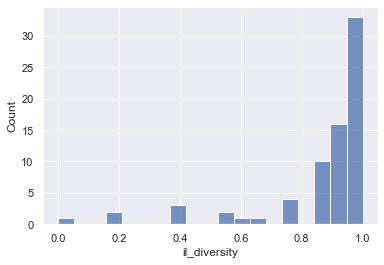

In [112]:
# calculate original intra-list diversity based on artists and draw histogram for the intralist diverity scores for the original recommendation list
dict_ild = il_diversity(recs_meta_top10)
user_ild = pd.DataFrame.from_dict(dict_ild, orient='index').reset_index().rename(columns={"index": "user", 0: "il_diversity"})
user_ild["type"] = "original_rec"

sns.histplot(data=user_ild, x="il_diversity")

As can be seen in the plot above, a lot already have an high il-diversity score. So for them the maximum diversification of the artists won't make any sense. This is however fixed by splitting the long and short term timestamps and only applying the diversification method that makes sense. 

### Maximize intra-list diversity


In [113]:
# Greedy diversification approach for maxmizing intra-list diversity
dict_rec_div = {}

for user in l_unique_user:
    if len(dict_rec_div)%10 == 0:
        print(len(dict_rec_div))
    
    user_recs = recs_meta[recs_meta["user"] == user]
    user_top_items = user_recs.item.tolist()

    rec_list = [user_top_items[0]]
    
    # For each item already in the recommendation list
    while(len(rec_list) < 10):
        j = 0
        max_diversity_score = 0
        max_item_id = -1
        
        # Iterate within the top 50 recommendations and find the item that maxmize the intra-list diversity
        for j in range(len(user_top_items)):
            tmp_item = user_top_items[j]
            tmp_item_artists = user_recs[user_recs["item"] == tmp_item].artists.values[0]
            tmp_item_artists_split = tmp_item_artists.split("|")
            
            mean_diversity_score = 0
            for i in range(len(rec_list)):
                list_item = rec_list[i]
                list_item_artists = user_recs[user_recs["item"] == list_item].artists.values[0]
                list_item_artists_split = list_item_artists.split("|")
                
                intersection = len(list(set(list_item_artists_split).intersection(set(tmp_item_artists_split))))
                union = len(list(set(list_item_artists_split).union(set(tmp_item_artists_split))))
                diversity_score = 1-float(intersection)/union
                mean_diversity_score = mean_diversity_score + diversity_score
            mean_diversity_score = mean_diversity_score/len(rec_list)
            
            if mean_diversity_score > max_diversity_score:                
                if tmp_item not in rec_list:
                    max_diversity_score = mean_diversity_score
                    max_item_id = tmp_item
        rec_list.append(max_item_id)
    dict_rec_div[user] = rec_list

0
10
20
30
40
50
60
70


In [114]:
# top 10 new recommendations after diversification
rec_div = pd.DataFrame.from_dict(dict_rec_div, orient='index').reset_index().rename(columns={"index": "user"})
rec_div = pd.melt(rec_div, id_vars=['user'], value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).rename(
    columns={"variable": "rank_new", "value": "item"})
rec_div_top10_max_artist = pd.merge(rec_div, tracks, on="item")

# start ranking from 1 rather than 0
rec_div_top10_max_artist["rank_new"] = rec_div_top10_max_artist["rank_new"] + 1
rec_div_top10_max_artist = rec_div_top10_max_artist.sort_values(by=["user", "rank_new"])

# add which kind of diversification
rec_div_top10_max_artist["type"] = "max_diversified_artist"
# rec_div_top10_max_artist

<AxesSubplot:xlabel='il_diversity', ylabel='Count'>

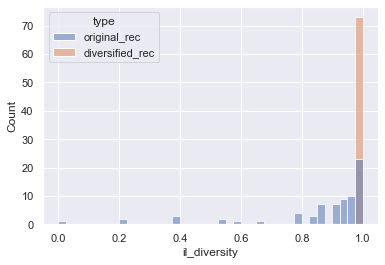

In [115]:
#Plotting the difference between original diversity score of the top 10 list and the new diversity score for top 10 within one histogram
dict_ild_div = il_diversity(rec_div_top10_max_artist)
user_ild_div = pd.DataFrame.from_dict(dict_ild_div, orient='index').reset_index().rename(columns={"index": "user", 0: "il_diversity"})
user_ild_div["type"] = "diversified_rec"

user_ild_combined = pd.concat([user_ild, user_ild_div]).reset_index(drop=True)
sns.histplot(data=user_ild_combined, x="il_diversity", hue="type")

Does not totally make sense to have diversified list with total diversification for every user > makes sense as top list consists of all unique artists

### Minimize intra-list diversity
For artists this does not really make sense. As a maximum diverse list consists (in prinicple) of 10 different artists, while a minimum diversified list consists of, if possible, 10 times the same artists with different songs. Thus, expected that you get list of all the same artists.

Impossible when the first artist is only in the list once, thus with one song. So mean diversity has to be equal to or smaller rather then smaller, in order to add new artist. New artist is only introduced when no new song with same artist is in users top 50. 

For, genre this made more sense as the 'list' of movies in said genre not endless is then next one, but still bigger than songs for artists

In [116]:
# Greedy diversification approach for minimizing intra-list diversity
dict_rec_div = {}

for user in l_unique_user:
    if len(dict_rec_div)%10 == 0:
        print(len(dict_rec_div))
    
    user_recs = recs_meta[recs_meta["user"] == user]
    user_top_items = user_recs.item.tolist()

    rec_list = [user_top_items[0]]
    # print(user)
    # For each item already in the recommendation list
    while(len(rec_list) < 10):
        j = 0
        min_diversity_score = 1
        max_item_id = -1

        # Iterate within the top 100 recommendations and find the item that maxmize the intra-list diversity
        for j in range(len(user_top_items)):
            tmp_item = user_top_items[j]
            tmp_item_artists = user_recs[user_recs["item"] == tmp_item].artists.values[0]
            tmp_item_artists_split = tmp_item_artists.split("|")
            
            mean_diversity_score = 0
            for i in range(len(rec_list)):
                list_item = rec_list[i]
                # print(user_recs[user_recs["item"] == list_item].artists)
                list_item_artists = user_recs[user_recs["item"] == list_item].artists.values[0]
                list_item_artists_split = list_item_artists.split("|")
                
                intersection = len(list(set(list_item_artists_split).intersection(set(tmp_item_artists_split))))
                union = len(list(set(list_item_artists_split).union(set(tmp_item_artists_split))))
                diversity_score = 1-float(intersection)/union              
                mean_diversity_score = mean_diversity_score + diversity_score
            mean_diversity_score = mean_diversity_score/len(rec_list)

            if mean_diversity_score <= min_diversity_score:             
                if tmp_item not in rec_list:
                    min_diversity_score = mean_diversity_score
                    max_item_id = tmp_item
        rec_list.append(max_item_id)
        # print(rec_list)
    dict_rec_div[user] = rec_list

0
10
20
30
40
50
60
70


In [142]:
# top 10 new recommendations after diversification
rec_div = pd.DataFrame.from_dict(dict_rec_div, orient='index').reset_index().rename(columns={"index": "user"})
rec_div = pd.melt(rec_div, id_vars=['user'], value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).rename(
    columns={"variable": "rank_new", "value": "item"})
rec_div_top10_min_artist = pd.merge(rec_div, tracks, on="item")

# start ranking from 1 rather than 0
rec_div_top10_min_artist["rank_new"] = rec_div_top10_min_artist["rank_new"] + 1
rec_div_top10_min_artist = rec_div_top10_min_artist.sort_values(by=["user", "rank_new"])

# add which kind of diversification
rec_div_top10_min_artist["type"] = "min_diversified_artist"
rec_div_top10_min_artist


,user,rank_new,item,trackname,popularity,artists,spotifyurl,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,type
0,00c8aae385389f159752b62e58288f9dc0bb7549dabc19...,1,20on25jryn53hWghthWWW3,Do It To It,83,ACRAZE,https://open.spotify.com/track/20on25jryn53hWg...,0.020900,0.854,157890,0.806,0.054200,11,0.0703,-8.262,0.0886,125,4,0.637,min_diversified_artist
155,00c8aae385389f159752b62e58288f9dc0bb7549dabc19...,2,2wso0v7nIbeOnMf078XSVQ,天黑黑 - Remastered,45,Stefanie Sun,https://open.spotify.com/track/2wso0v7nIbeOnMf...,0.939000,0.495,237066,0.223,0.000019,8,0.1210,-12.484,0.0409,109,4,0.394,min_diversified_artist
203,00c8aae385389f159752b62e58288f9dc0bb7549dabc19...,3,2bzitsPcImYC6DZWvvLCQi,"Zero - From the Original Motion Picture ""Ralph...",70,Imagine Dragons,https://open.spotify.com/track/2bzitsPcImYC6DZ...,0.000479,0.634,210933,0.662,0.001420,6,0.1110,-7.543,0.0325,90,4,0.244,min_diversified_artist
409,00c8aae385389f159752b62e58288f9dc0bb7549dabc19...,4,1gEPQfklgXi4DGHjWJY2Cv,The Sights,42,Enter Shikari,https://open.spotify.com/track/1gEPQfklgXi4DGH...,0.143000,0.508,200520,0.767,0.000000,0,0.1620,-9.178,0.0676,178,4,0.414,min_diversified_artist
399,00c8aae385389f159752b62e58288f9dc0bb7549dabc19...,5,0VO8gYVDSwM1Qdd2GsMoYK,Moth To A Flame (with The Weeknd),81,Swedish House Mafia,https://open.spotify.com/track/0VO8gYVDSwM1Qdd...,0.002700,0.553,234000,0.659,0.000000,8,0.1050,-7.295,0.0391,120,4,0.105,min_diversified_artist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,fc8ef674e488a7487a5aff9a162b98f27a52a6636652fd...,6,3IvTwPCCjfZczCN2k4qPiH,Dirty Work,51,Steely Dan,https://open.spotify.com/track/3IvTwPCCjfZczCN...,0.767000,0.582,190065,0.214,0.000002,1,0.1220,-17.830,0.0315,73,4,0.515,min_diversified_artist
654,fc8ef674e488a7487a5aff9a162b98f27a52a6636652fd...,7,6EQjfk54NVJkA4oZGlwuiM,More Than a Feeling,39,Boston,https://open.spotify.com/track/6EQjfk54NVJkA4o...,0.002550,0.417,285066,0.669,0.000085,7,0.0398,-8.109,0.0269,109,4,0.375,min_diversified_artist
686,fc8ef674e488a7487a5aff9a162b98f27a52a6636652fd...,8,1R8oVag35gYmoKeH2BWhSM,Come To California,14,Caroline D'Amore,https://open.spotify.com/track/1R8oVag35gYmoKe...,0.031900,0.656,224106,0.971,0.000023,2,0.4040,-1.492,0.1010,120,4,0.619,min_diversified_artist
707,fc8ef674e488a7487a5aff9a162b98f27a52a6636652fd...,9,4d6eqRtpDX7tydHJGDZUBQ,She Drives Me Crazy,74,Fine Young Cannibals,https://open.spotify.com/track/4d6eqRtpDX7tydH...,0.193000,0.799,215773,0.687,0.000188,2,0.0307,-5.682,0.0431,109,4,0.965,min_diversified_artist


<AxesSubplot:xlabel='il_diversity', ylabel='Count'>

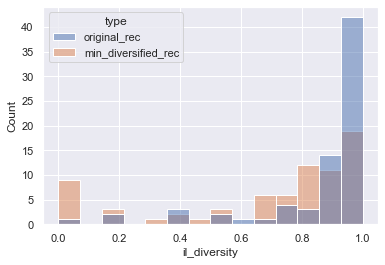

In [119]:
#Plotting the difference between original diversity score of the top 10 list and the new diversity score for top 10 within one histogram
dict_ild_div = il_diversity(rec_div_top10_min_artist)
user_ild_div = pd.DataFrame.from_dict(dict_ild_div, orient='index').reset_index().rename(columns={"index": "user", 0: "il_diversity"})
user_ild_div["type"] = "min_diversified_rec"
# user_ild_div

user_ild_combined = pd.concat([user_ild, user_ild_div]).reset_index(drop=True)
sns.histplot(data=user_ild_combined, x="il_diversity", hue="type")

So minimizing diversity does indeed work, however, still a lot in the upper region. This could have been expected as the amount of artist with multiple songs in the top 50 of an user is not extensive (over 10) in most cases, thus another artist must be chosen from their top 50. In the user was very diverse, the change of having multiple times the same artist in it, is very small. Indicating still a relatively high il-diversity

# Diversification based on acousticness
Below can be done for each characteristic, but not for all together. Or does anyone have any idea on how to do this?

This is based on the input files of our research step 1, rather than the experimentation on top in contrast to artist part.

In [84]:
# Get the top 10 recommendations
recs_non_diverse_top10 = recs_non_diverse[recs_non_diverse["rank"] <= 10]
recs_non_diverse_top10

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,tempo,type,item,uri,track_href,analysis_url,duration_ms,time_signature,user,rank
0,0,0.376,0.80900,5.0,-3.905,1.0,0.1680,0.0339,0.096500,0.6880,...,121.887,audio_features,3ZbmDl4M9O587VmD9IqyIj,spotify:track:3ZbmDl4M9O587VmD9IqyIj,https://api.spotify.com/v1/tracks/3ZbmDl4M9O58...,https://api.spotify.com/v1/audio-analysis/3Zbm...,269040.0,4.0,d28708a363b58062087293f779256fffa38fdd56c1f79d...,1
1,1,0.725,0.39400,8.0,-7.120,1.0,0.1640,0.1140,0.000000,0.0794,...,81.176,audio_features,7FA2oxGAfveiECwzeUqOja,spotify:track:7FA2oxGAfveiECwzeUqOja,https://api.spotify.com/v1/tracks/7FA2oxGAfvei...,https://api.spotify.com/v1/audio-analysis/7FA2...,215720.0,4.0,d28708a363b58062087293f779256fffa38fdd56c1f79d...,2
2,2,0.438,0.89400,8.0,-4.247,0.0,0.1080,0.0030,0.000000,0.2990,...,126.958,audio_features,3eunKmoXb7y9D5xmbGbfW5,spotify:track:3eunKmoXb7y9D5xmbGbfW5,https://api.spotify.com/v1/tracks/3eunKmoXb7y9...,https://api.spotify.com/v1/audio-analysis/3eun...,162040.0,4.0,d28708a363b58062087293f779256fffa38fdd56c1f79d...,3
3,3,0.715,0.35000,11.0,-13.846,1.0,0.1210,0.0469,0.000000,0.0724,...,81.682,audio_features,0j2hYbbYeadrfJgII5bhea,spotify:track:0j2hYbbYeadrfJgII5bhea,https://api.spotify.com/v1/tracks/0j2hYbbYeadr...,https://api.spotify.com/v1/audio-analysis/0j2h...,213360.0,4.0,d28708a363b58062087293f779256fffa38fdd56c1f79d...,4
4,4,0.766,0.42700,4.0,-10.959,0.0,0.3360,0.7310,0.000572,0.1840,...,74.063,audio_features,2p6WDr28CJXYNglfrneMLL,spotify:track:2p6WDr28CJXYNglfrneMLL,https://api.spotify.com/v1/tracks/2p6WDr28CJXY...,https://api.spotify.com/v1/audio-analysis/2p6W...,206200.0,4.0,d28708a363b58062087293f779256fffa38fdd56c1f79d...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,5,0.519,0.22700,5.0,-13.170,1.0,0.0836,0.9740,0.300000,0.0825,...,71.361,audio_features,0ZAyQDwokbChHvAdYkb5h7,spotify:track:0ZAyQDwokbChHvAdYkb5h7,https://api.spotify.com/v1/tracks/0ZAyQDwokbCh...,https://api.spotify.com/v1/audio-analysis/0ZAy...,176707.0,4.0,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,6
4306,6,0.444,0.85700,7.0,-6.048,1.0,0.0649,0.0182,0.000000,0.0974,...,204.185,audio_features,31x5AEDDIkZ7x6mYbYQSAe,spotify:track:31x5AEDDIkZ7x6mYbYQSAe,https://api.spotify.com/v1/tracks/31x5AEDDIkZ7...,https://api.spotify.com/v1/audio-analysis/31x5...,176000.0,4.0,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,7
4307,7,0.822,0.60100,5.0,-5.418,0.0,0.2970,0.4150,0.000000,0.0797,...,96.123,audio_features,4HRDBtek0ayfLQ6uc7rjO9,spotify:track:4HRDBtek0ayfLQ6uc7rjO9,https://api.spotify.com/v1/tracks/4HRDBtek0ayf...,https://api.spotify.com/v1/audio-analysis/4HRD...,243700.0,4.0,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,8
4308,8,0.511,0.49600,7.0,-9.212,0.0,0.0380,0.7050,0.000031,0.0975,...,95.531,audio_features,6g7OHPX0nK6Sl4GOEnzHP5,spotify:track:6g7OHPX0nK6Sl4GOEnzHP5,https://api.spotify.com/v1/tracks/6g7OHPX0nK6S...,https://api.spotify.com/v1/audio-analysis/6g7O...,626827.0,4.0,508580d6e4f48b7c202c93bc3a485a116fb850b65102f5...,9


In [86]:
# Calculate the unique artists in the top ten for each user 
l_unique_user = recs_non_diverse_top10.user.unique().tolist()

dict_unique_acous = {}

for user in l_unique_user:
    user_top_acous = recs_non_diverse_top10[recs_non_diverse_top10["user"] == user].acousticness.tolist()
    dict_unique_acous[user] = len(dict(Counter(user_top_acous)))
    
df_unique_acous = pd.DataFrame.from_dict(dict_unique_acous, 
                                          orient='index').reset_index().rename(columns={"index": "user", 0: "num_unique_acous"})

# List of unique acousticness
list_acous = recs_non_diverse_top10.acousticness.tolist()

dict_acous_counter = dict(Counter(list_acous))
df_acous_counter = pd.DataFrame.from_dict(dict_acous_counter, 
                                          orient='index').reset_index().rename(columns={"index": "acousticness", 0: "counts"})
df_acous_counter["type"] = "original recs"
df_acous_counter = df_acous_counter.sort_values(by="acousticness")

dict_intradistance = {}
acousticness = df_acous_counter.sort_values(by="acousticness").acousticness.unique().tolist()
print(acousticness)

[1.95e-06, 4.34e-06, 7.19e-06, 7.92e-06, 1.08e-05, 1.34e-05, 3.08e-05, 3.39e-05, 5.37e-05, 6.15e-05, 6.34e-05, 7.07e-05, 8.62e-05, 8.93e-05, 0.000105, 0.000133, 0.000137, 0.000179, 0.000215, 0.000216, 0.000249, 0.000266, 0.000277, 0.00031, 0.000313, 0.00032, 0.000364, 0.000369, 0.000462, 0.000519, 0.000563, 0.00058, 0.000594, 0.00063, 0.000662, 0.000815, 0.000873, 0.000891, 0.000911, 0.000916, 0.000972, 0.00102, 0.00115, 0.00119, 0.00128, 0.00137, 0.00146, 0.00157, 0.0016, 0.00161, 0.0017, 0.00183, 0.00184, 0.00206, 0.00235, 0.00252, 0.00262, 0.00271, 0.003, 0.00301, 0.00302, 0.0033, 0.00335, 0.00339, 0.00364, 0.00379, 0.00382, 0.00386, 0.0039, 0.00413, 0.00483, 0.0054, 0.00541, 0.00556, 0.00562, 0.00563, 0.00584, 0.00612, 0.00655, 0.00657, 0.00716, 0.00744, 0.00755, 0.00771, 0.00825, 0.00864, 0.00899, 0.009, 0.00933, 0.00958, 0.00971, 0.00979, 0.0101, 0.0102, 0.0123, 0.0129, 0.0133, 0.0135, 0.0139, 0.014, 0.0141, 0.0143, 0.0145, 0.0148, 0.015, 0.0152, 0.0155, 0.0156, 0.017, 0.0178, 0.

In [87]:
# Function for Intra-list Diversity acousticness
def il_diversity_int(recs):
    dict_ild = {}
    l_unique_user = recs.user.unique().tolist()
    for user in l_unique_user:
        user_top_acous = recs[recs["user"] == user].acousticness.tolist()
    
        ild = 0
        # Calculate the pairwise difference with jaccard simliarity for all items in the top 10
        for i in range(len(user_top_acous)):
            current_item = user_top_acous[i]
            for j in range(i+1, len(user_top_acous)):
                tmp_item = user_top_acous[j]
                
                ild = ild + 1 - abs(current_item-tmp_item)/(current_item+tmp_item) #float(intersection)/union
        ild = ild/math.comb(len(user_top_acous), 2)
        dict_ild[user] = ild
    return dict_ild

<AxesSubplot:xlabel='il_diversity', ylabel='Count'>

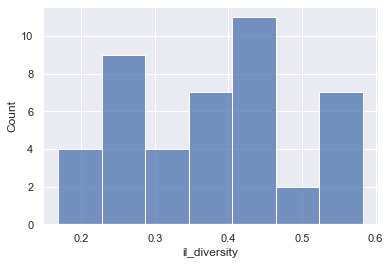

In [88]:
#Plotting the original diversity score of the top 10 list
dict_ild = il_diversity_int(recs_non_diverse_top10)
user_ild = pd.DataFrame.from_dict(dict_ild, orient='index').reset_index().rename(columns={"index": "user", 0: "il_diversity"})
user_ild["type"] = "original_rec"
# user_ild

sns.histplot(data=user_ild, x="il_diversity")

Indeed more lower diversity

### Maximum diversification by acousticness

In [89]:
# Greedy diversification approach for maxmizing intra-list diversity
dict_rec_div = {}

for user in l_unique_user:
    if len(dict_rec_div)%10 == 0:
        print(len(dict_rec_div))
    
    user_recs = recs_non_diverse[recs_non_diverse["user"] == user]
    user_top_items = user_recs.item.tolist()

    rec_list = [user_top_items[0]]
    
    # For each item already in the recommendation list
    while(len(rec_list) < 10):
        j = 0
        max_diversity_score = 0
        max_item_id = -1
        
        # Iterate within the top 50 recommendations and find the item that maxmize the intra-list diversity
        for j in range(len(user_top_items)):
            tmp_item = user_top_items[j]
            tmp_item_acous = user_recs[user_recs["item"] == tmp_item].acousticness.values[0]
            
            mean_diversity_score = 0
            for i in range(len(rec_list)):
                list_item = rec_list[i]
                list_item_acous = user_recs[user_recs["item"] == list_item].acousticness.values[0]
                
                diversity_score = 1-abs(list_item_acous - tmp_item_acous) / (list_item_acous + tmp_item_acous)
                mean_diversity_score = mean_diversity_score + diversity_score
            mean_diversity_score = mean_diversity_score/len(rec_list)
            
            if mean_diversity_score > max_diversity_score:                
                if tmp_item not in rec_list:
                    max_diversity_score = mean_diversity_score
                    max_item_id = tmp_item
        rec_list.append(max_item_id)
    dict_rec_div[user] = rec_list

0
10
20
30
40


In [90]:
# top 10 new recommendations after diversification
rec_div = pd.DataFrame.from_dict(dict_rec_div, orient='index').reset_index().rename(columns={"index": "user"})
rec_div = pd.melt(rec_div, id_vars=['user'], value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).rename(
    columns={"variable": "rank_new", "value": "item"})
rec_div_top10_max_acous = pd.merge(rec_div, recs_non_diverse[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                                                            'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'item', 'uri', 'track_href', 
                                                            'analysis_url','duration_ms', 'time_signature', 'rank']], on="item")

# start ranking from 1 rather than 0
rec_div_top10_max_acous["rank_new"] = rec_div_top10_max_acous["rank_new"] + 1
rec_div_top10_max_acous = rec_div_top10_max_acous.sort_values(by=["user", "rank_new"])

# add which kind of diversification
rec_div_top10_max_acous["type"] = "max_diversified_acous"
rec_div_top10_max_acous

,user,rank_new,item,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,rank
16,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,1,2nipunG6cOdAt5Rf8Njgz2,0.666,0.819,8.0,-5.936,1.0,0.0394,0.433,...,0.1170,0.498,123.058,max_diversified_acous,spotify:track:2nipunG6cOdAt5Rf8Njgz2,https://api.spotify.com/v1/tracks/2nipunG6cOdA...,https://api.spotify.com/v1/audio-analysis/2nip...,185806.0,4.0,1
81,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,2,1WeJyLl7sHfXasJDshFuka,0.522,0.684,7.0,-10.288,1.0,0.0908,0.431,...,0.1090,0.490,89.104,max_diversified_acous,spotify:track:1WeJyLl7sHfXasJDshFuka,https://api.spotify.com/v1/tracks/1WeJyLl7sHfX...,https://api.spotify.com/v1/audio-analysis/1WeJ...,190547.0,4.0,9
132,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,3,6VOtFViH04LYfhpoonBALh,0.795,0.511,11.0,-6.477,1.0,0.0806,0.430,...,0.1220,0.160,134.984,max_diversified_acous,spotify:track:6VOtFViH04LYfhpoonBALh,https://api.spotify.com/v1/tracks/6VOtFViH04LY...,https://api.spotify.com/v1/audio-analysis/6VOt...,165261.0,4.0,94
194,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,4,44aXRKLyvcxF7alLbItB4Q,0.797,0.572,8.0,-9.098,1.0,0.1480,0.453,...,0.1660,0.725,129.888,max_diversified_acous,spotify:track:44aXRKLyvcxF7alLbItB4Q,https://api.spotify.com/v1/tracks/44aXRKLyvcxF...,https://api.spotify.com/v1/audio-analysis/44aX...,212308.0,4.0,6
251,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,5,6DngEhJA9AtvfN32e0XM1l,0.596,0.673,2.0,-7.545,1.0,0.0517,0.465,...,0.1560,0.707,130.023,max_diversified_acous,spotify:track:6DngEhJA9AtvfN32e0XM1l,https://api.spotify.com/v1/tracks/6DngEhJA9Atv...,https://api.spotify.com/v1/audio-analysis/6Dng...,284000.0,4.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,6,0Hhft3gXN78dN2AowVLr2E,0.648,0.649,5.0,-6.692,0.0,0.2920,0.182,...,0.1150,0.516,86.783,max_diversified_acous,spotify:track:0Hhft3gXN78dN2AowVLr2E,https://api.spotify.com/v1/tracks/0Hhft3gXN78d...,https://api.spotify.com/v1/audio-analysis/0Hhf...,171042.0,4.0,31
383,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,7,71JBAmEVHPb6Ww4j7340bJ,0.604,0.885,8.0,-11.090,0.0,0.0561,0.182,...,0.0925,0.119,150.069,max_diversified_acous,spotify:track:71JBAmEVHPb6Ww4j7340bJ,https://api.spotify.com/v1/tracks/71JBAmEVHPb6...,https://api.spotify.com/v1/audio-analysis/71JB...,133312.0,4.0,39
431,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,8,6IeYW1DypX7ElJbALc14z5,0.864,0.887,9.0,-5.846,0.0,0.0729,0.183,...,0.1000,0.904,129.990,max_diversified_acous,spotify:track:6IeYW1DypX7ElJbALc14z5,https://api.spotify.com/v1/tracks/6IeYW1DypX7E...,https://api.spotify.com/v1/audio-analysis/6IeY...,131539.0,4.0,82
490,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,9,1hAyXQ5yfTmsNpgABqMupu,0.660,0.535,8.0,-8.399,1.0,0.0480,0.185,...,0.0798,0.371,116.947,max_diversified_acous,spotify:track:1hAyXQ5yfTmsNpgABqMupu,https://api.spotify.com/v1/tracks/1hAyXQ5yfTms...,https://api.spotify.com/v1/audio-analysis/1hAy...,175935.0,4.0,11


<AxesSubplot:xlabel='il_diversity', ylabel='Count'>

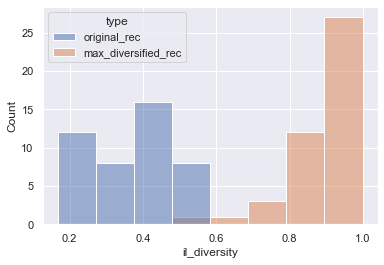

In [91]:
# Plotting the difference between original diversity score of the top 10 list and the new diversity score for top 10 within one histogram
dict_ild_div = il_diversity_int(rec_div_top10_max_acous)
user_ild_div_max = pd.DataFrame.from_dict(dict_ild_div, orient='index').reset_index().rename(columns={"index": "user", 0: "il_diversity"})
user_ild_div_max["type"] = "max_diversified_rec"
user_ild_div_max

user_ild_combined = pd.concat([user_ild, user_ild_div_max]).reset_index(drop=True)
sns.histplot(data=user_ild_combined, x="il_diversity", hue="type")

### Minimize diversity based on acousticness
For acousticness, equal to mean diversity is not needed as the values are most often either smaller or bigger and there is some kind of ranking in this. The algorithm knows what is closer and what is not. While for text/string it does not know what is more the same than another, only if it is equal to or not in writing. 

In [92]:
# Greedy diversification approach for minimize intra-list diversity
dict_rec_div = {}

for user in l_unique_user:
    if len(dict_rec_div)%10 == 0:
        print(len(dict_rec_div))
    
    user_recs = recs_diverse[recs_diverse["user"] == user]
    user_top_items = user_recs.item.tolist()

    rec_list = [user_top_items[0]]
    
    # For each item already in the recommendation list
    while(len(rec_list) < 10):
        j = 0
        min_diversity_score = 1
        max_item_id = -1
        
        # Iterate within the top 50 recommendations and find the item that minimize the intra-list diversity
        for j in range(len(user_top_items)):
            tmp_item = user_top_items[j]
            tmp_item_acous = user_recs[user_recs["item"] == tmp_item].acousticness.values[0]
            
            mean_diversity_score = 0
            for i in range(len(rec_list)):
                list_item = rec_list[i]
                list_item_acous = user_recs[user_recs["item"] == list_item].acousticness.values[0]
                
                diversity_score = 1-abs(list_item_acous - tmp_item_acous)/(list_item_acous + tmp_item_acous)
                mean_diversity_score = mean_diversity_score + diversity_score
            mean_diversity_score = mean_diversity_score/len(rec_list)
            
            if mean_diversity_score < min_diversity_score:               # HERE THE EQUAL TO IS NOT NECESSARY, CAN BE SMALLER IN ALL CASES 
                if tmp_item not in rec_list:
                    min_diversity_score = mean_diversity_score
                    max_item_id = tmp_item
        rec_list.append(max_item_id)
    dict_rec_div[user] = rec_list

0


C:\Users\kimge\AppData\Local\Temp/ipykernel_22900/2189751181.py:29: RuntimeWarning: invalid value encountered in double_scalars
  diversity_score = 1-abs(list_item_acous - tmp_item_acous)/(list_item_acous + tmp_item_acous)


10
20
30
40


In [93]:
# top 10 new recommendations after diversification
rec_div = pd.DataFrame.from_dict(dict_rec_div, orient='index').reset_index().rename(columns={"index": "user"})
rec_div = pd.melt(rec_div, id_vars=['user'], value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).rename(
    columns={"variable": "rank_new", "value": "item"})
rec_div_top10_min_acous = pd.merge(rec_div, recs_diverse[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                                                            'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'item', 'uri', 'track_href', 
                                                            'analysis_url','duration_ms', 'time_signature', 'rank']], on="item")

# start ranking from 1 rather than 0
rec_div_top10_min_acous["rank_new"] = rec_div_top10_min_acous["rank_new"] + 1
rec_div_top10_min_acous = rec_div_top10_min_acous.sort_values(by=["user", "rank_new"])

# add which kind of diversification
rec_div_top10_min_acous["type"] = "min_diversified_acous"
rec_div_top10_min_acous

,user,rank_new,item,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,rank
19,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,1,33Po4wZNmlLhd5VJTkA0RC,0.343,0.944,7,-5.178,1,0.1250,0.007600,...,0.8630,0.342,174.200,min_diversified_acous,spotify:track:33Po4wZNmlLhd5VJTkA0RC,https://api.spotify.com/v1/tracks/33Po4wZNmlLh...,https://api.spotify.com/v1/audio-analysis/33Po...,224440,4,1
78,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,2,0WPlNl4tqrfzihBLTgJQZx,0.575,0.969,10,-4.903,0,0.0456,0.000034,...,0.1720,0.719,106.270,min_diversified_acous,spotify:track:0WPlNl4tqrfzihBLTgJQZx,https://api.spotify.com/v1/tracks/0WPlNl4tqrfz...,https://api.spotify.com/v1/audio-analysis/0WPl...,243853,4,24
138,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,3,3XjAgiBvWBKu1tHSLTgffX,0.689,0.143,6,-17.374,1,0.2640,0.970000,...,0.1090,0.528,85.398,min_diversified_acous,spotify:track:3XjAgiBvWBKu1tHSLTgffX,https://api.spotify.com/v1/tracks/3XjAgiBvWBKu...,https://api.spotify.com/v1/audio-analysis/3XjA...,198220,4,62
139,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,3,3XjAgiBvWBKu1tHSLTgffX,0.689,0.143,6,-17.374,1,0.2640,0.970000,...,0.1090,0.528,85.398,min_diversified_acous,spotify:track:3XjAgiBvWBKu1tHSLTgffX,https://api.spotify.com/v1/tracks/3XjAgiBvWBKu...,https://api.spotify.com/v1/audio-analysis/3XjA...,198220,4,22
193,021232e9130550d1df9cebb0b1691d55bd271a1ec04b1e...,4,1uEuVi8nSI6Y2VzJj6DoDd,0.649,0.947,6,-6.071,1,0.0824,0.000375,...,0.1040,0.551,101.379,min_diversified_acous,spotify:track:1uEuVi8nSI6Y2VzJj6DoDd,https://api.spotify.com/v1/tracks/1uEuVi8nSI6Y...,https://api.spotify.com/v1/audio-analysis/1uEu...,268067,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,7,1XPZw4mB0ng7K1LvYXcUe8,0.644,0.482,11,-8.072,1,0.0307,0.627000,...,0.0905,0.217,106.966,min_diversified_acous,spotify:track:1XPZw4mB0ng7K1LvYXcUe8,https://api.spotify.com/v1/tracks/1XPZw4mB0ng7...,https://api.spotify.com/v1/audio-analysis/1XPZ...,192932,4,60
238,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,8,4cluDES4hQEUhmXj6TXkSo,0.726,0.787,4,-2.494,1,0.0737,0.009000,...,0.0596,0.888,124.990,min_diversified_acous,spotify:track:4cluDES4hQEUhmXj6TXkSo,https://api.spotify.com/v1/tracks/4cluDES4hQEU...,https://api.spotify.com/v1/audio-analysis/4clu...,199987,4,3
239,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,8,4cluDES4hQEUhmXj6TXkSo,0.726,0.787,4,-2.494,1,0.0737,0.009000,...,0.0596,0.888,124.990,min_diversified_acous,spotify:track:4cluDES4hQEUhmXj6TXkSo,https://api.spotify.com/v1/tracks/4cluDES4hQEU...,https://api.spotify.com/v1/audio-analysis/4clu...,199987,4,71
487,f8a05048192e67c19fb9afa712456b4a600682184d3f49...,9,6JlJtgJIlMhp8sQ1tKBfdv,0.541,0.291,0,-9.478,1,0.0344,0.968000,...,0.7080,0.188,133.444,min_diversified_acous,spotify:track:6JlJtgJIlMhp8sQ1tKBfdv,https://api.spotify.com/v1/tracks/6JlJtgJIlMhp...,https://api.spotify.com/v1/audio-analysis/6JlJ...,206133,4,77


<AxesSubplot:xlabel='il_diversity', ylabel='Count'>

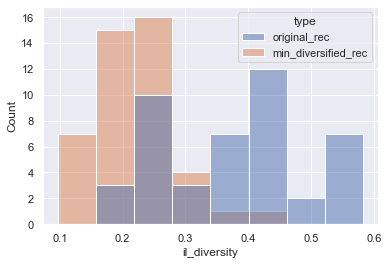

In [94]:
# Plotting the difference between original diversity score of the top 10 list and the new diversity score for top 10 within one histogram
dict_ild_div = il_diversity_int(rec_div_top10_min_acous)
user_ild_div_min = pd.DataFrame.from_dict(dict_ild_div, orient='index').reset_index().rename(columns={"index": "user", 0: "il_diversity"})
user_ild_div_min["type"] = "min_diversified_rec"
# user_ild_div_min

user_ild_combined = pd.concat([user_ild, user_ild_div_min]).reset_index(drop=True)
sns.histplot(data=user_ild_combined, x="il_diversity", hue="type")

### Trying a contour plot
No succes achieved in any way

In [81]:
acoustic = recs_diverse['acousticness'].unique().tolist()
dance = recs_diverse['danceability'].unique().tolist()

acoustic= np.linspace(0, 44, 1)
dance = np.linspace(0, 44, 1)

diversity = user_ild['il_diversity'].unique()
new_diversity = user_ild_div_min['il_diversity'].unique()
working = diversity,new_diversity
working


(array([0.3497674 , 0.32259576, 0.33254241, 0.65738496, 0.57518508,
        0.64420741, 0.65452116, 0.57579893, 0.42530383, 0.29704217,
        0.36922098, 0.69879436, 0.25566066, 0.44254793, 0.39158116,
        0.27926802, 0.23757322, 0.34772584, 0.41875025, 0.17683799,
        0.22360084, 0.29801058, 0.26708544, 0.39585551, 0.31009256,
        0.5630166 , 0.53359984, 0.39880829, 0.32536396, 0.42261299,
        0.58547885, 0.28272973, 0.43196022, 0.2762375 , 0.52746646,
        0.28449333, 0.29609442, 0.36065345, 0.62236345, 0.41720811,
        0.28836379, 0.42900468, 0.46016317, 0.36527676]),
 array([0.41718217, 0.21099349, 0.41262838, 0.4843881 , 0.26547071,
        0.19132315, 0.62136092, 0.70163614, 0.2745842 , 0.26981577,
        0.21523317, 0.36711409, 0.49335914, 0.25093607, 0.21989348,
        0.588678  , 0.35493635, 0.44104845, 0.526145  , 0.29655991,
        0.13163115, 0.58096841, 0.40285506, 0.21569055, 0.40966063,
        0.4792713 , 0.6383156 , 0.3850584 , 0.33033856, 0.

TypeError: Shapes of x (1, 1) and z (2, 44) do not match

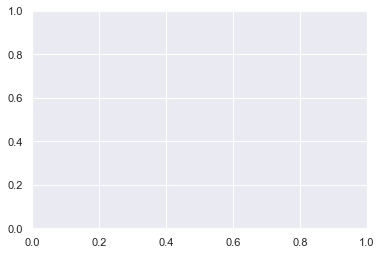

In [78]:
import plotly.graph_objects as go

fig = go.Figure(data =
    go.Contour(
        z=[diversity,new_diversity]
    ))
fig.show()

# List in required format for part 3 Asaf
rec_div_top10 = dataframe input for next part

In [97]:
rec_div_top10_max_acous.to_csv('max_diversified_recommendations_non_diverse.csv')
rec_div_top10_min_acous.to_csv('min_diversified_recommendations_diverse.csv')
